In [4]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
import statsmodels.formula.api as smf

In [5]:
data = pd.read_excel("C:\\Users\\Asus\\CocaCola_Sales_Rawdata.xlsx")
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [6]:
data.shape

(42, 2)

In [7]:
data.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [8]:
data['Quarters']= 0
data['Year'] = 0
for i in range(42):
    p = data["Quarter"][i]
    data['Quarters'][i]= p[0:2]
    data['Year'][i]= p[3:5]

<ipython-input-8-71bede3346bd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Quarters'][i]= p[0:2]
C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-8-71bede3346bd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year'][i]= p[3:5]


In [9]:
# Prepring dummies 
Quarters_Dummies = pd.DataFrame(pd.get_dummies(data['Quarters']))
df = pd.concat([data,Quarters_Dummies],axis = 1)

In [10]:
df.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


In [11]:
df.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


<AxesSubplot:>

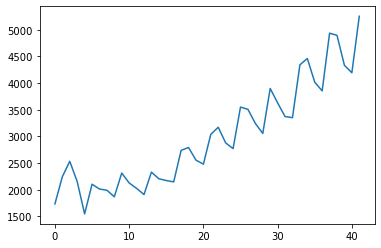

In [12]:
df.Sales.plot()

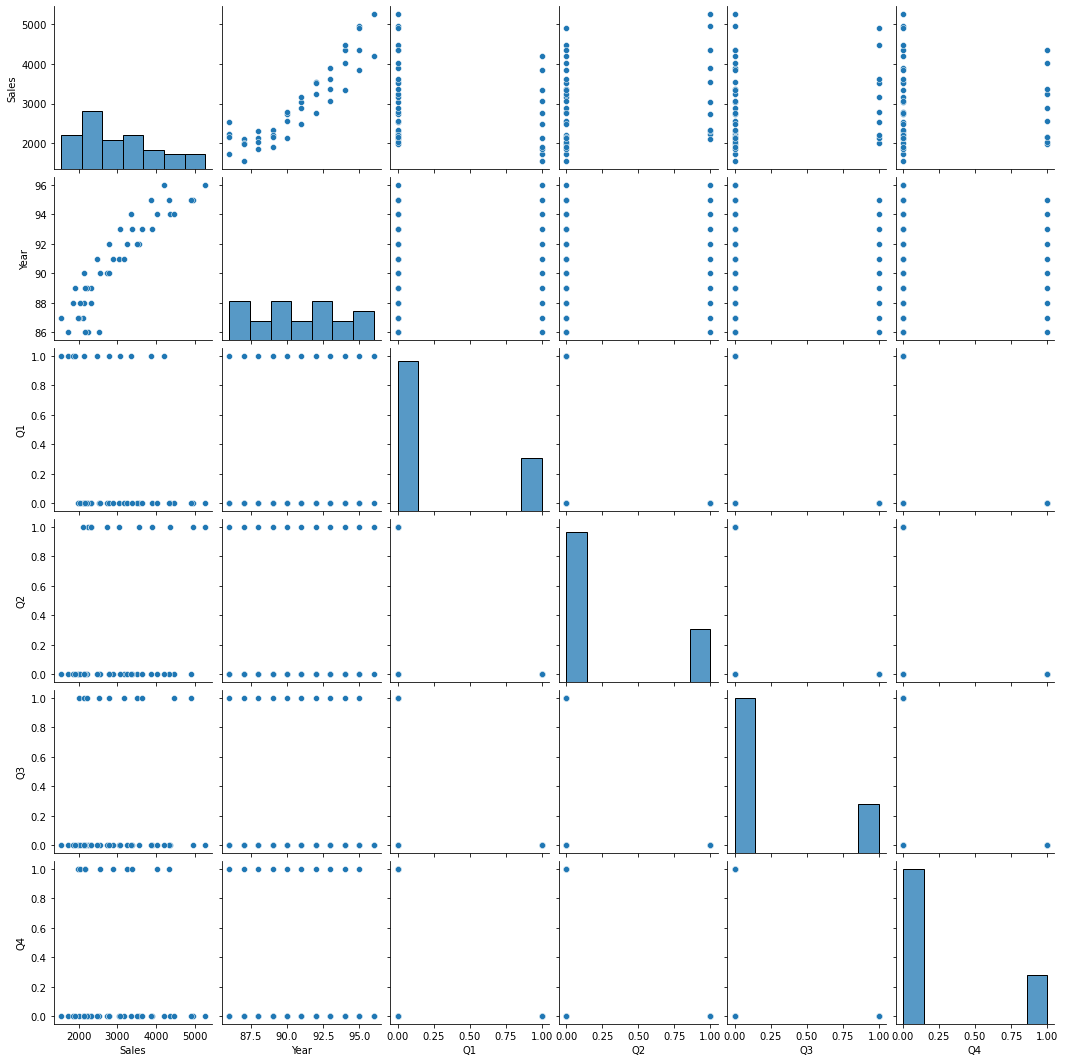

In [13]:
import seaborn as sns
sns.pairplot(df, diag_kind="hist")

<AxesSubplot:xlabel='Quarters', ylabel='Year'>

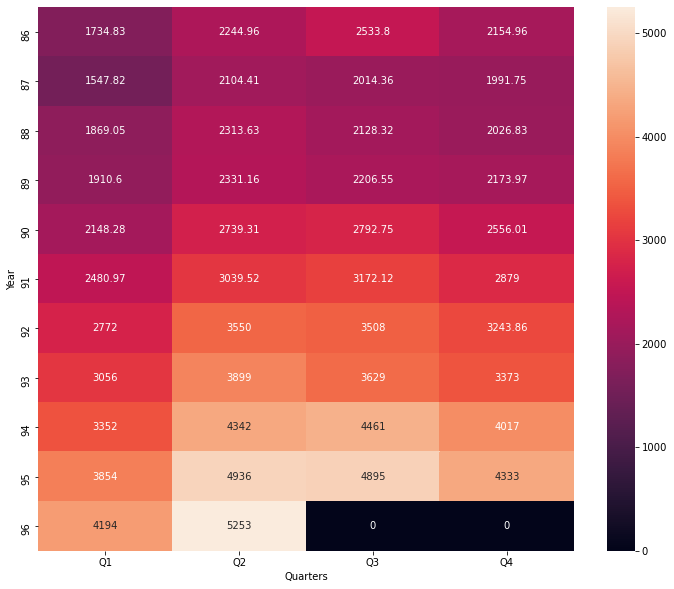

In [14]:
# visualize the data

plt.figure(figsize=(12,10))
plot_month_y = pd.pivot_table(data = df,values="Sales",index="Year",columns="Quarters"
                             ,aggfunc="mean",fill_value=0)
sns.heatmap(plot_month_y,annot=True,fmt = "g")

<AxesSubplot:xlabel='Year', ylabel='Sales'>

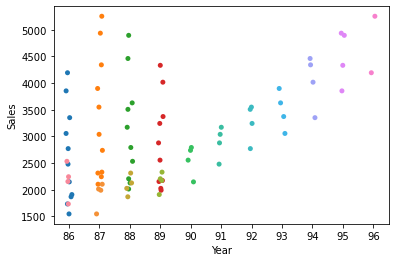

In [15]:
sns.stripplot(x="Quarters",y="Sales",data=df)
sns.stripplot(x="Year",y="Sales",data=df)

In [16]:
df["t"]=np.arange(1,43)

In [17]:
df["t_squared"] = df["t"]*df["t"]
df.columns

Index(['Quarter', 'Sales', 'Quarters', 'Year', 'Q1', 'Q2', 'Q3', 'Q4', 't',
       't_squared'],
      dtype='object')

In [18]:
df["Log_Sales"]=np.log(df["Sales"])

In [19]:
Train = df.head(38)
Test = df.tail(3)

In [20]:
# Linear model
import statsmodels.formula.api as smf
linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

528.5011156808132

In [21]:
# Exponential
Exp = smf.ols('Log_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

412.52654065106304

In [22]:
# Quadratic
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

533.4189445567946

In [23]:
# Additive seasonality
add_sea = smf.ols('Sales~Q1+Q2+Q3',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1','Q2','Q3']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1826.7096764020114

In [24]:
# Additive Seasonality Quadratic
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1','Q2','Q3','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad 

347.55917055416546

In [25]:

# Multiplicative Seasonality
Mul_sea = smf.ols('Log_Sales~Q1+Q2+Q3',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea


1932.2630496766442

In [26]:
# Multiplicative Additive Seasonality
Mul_Add_sea = smf.ols('Log_Sales~t+Q1+Q2+Q3',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

171.16949627599033

In [27]:

#tabulating the rmse values

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse



,MODEL,RMSE_Values
0,rmse_linear,528.501116
1,rmse_Exp,412.526541
2,rmse_Quad,533.418945
3,rmse_add_sea,1826.709676
4,rmse_add_sea_quad,347.559171
5,rmse_Mult_sea,1932.263050
6,rmse_Mult_add_sea,171.169496


In [30]:
#predict with the new data
df_new = pd.read_excel("C:\\Users\\Asus\\CocaCola_Sales_Rawdata.xlsx")
df_new

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


## 225.52439049818733  
## multiplicative additive seasonality is best model